In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
import sys 
import os
sys.path.append('../')
sys.path.append('../../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



# Herron-Langway Density Profile Example

In [11]:
T0s = np.asarray([-57.0,-54.5,-30.4,-31.0,-28.0]) + 273.15#np.asarray([-54.5, -57.0, -31.0, -28.0, -30.4]) + 273.15#np.asarray([-30.37, -30.4, -29.41, -24.29, -22.3]) + 273.15
sites = ['Vostok','EPICA','Crete','NEEM','EGRIP']#['EPICA', 'Vostok', 'NEEM', 'EGRIP', 'Crete']#['Site E', 'Crete', 'Site A', 'Camp Century', 'Milcent']


A0s = np.asarray([0.024,0.025,0.28,0.22,0.11])#np.asarray([0.025, 0.024, 0.22, 0.11, 0.28])*(917/1000)#np.asarray([0.225, 0.28, 0.307, 0.38, 0.53]) * (917/1000)
z = np.linspace(0,100,1000)


models = []

for i in range(len(T0s)):
    HL_inst = HL_Thea(Temp_0 = T0s[i], Acc_0 = A0s[i])

    HL_model = HL_inst.model(z)
    models.append(HL_model)

In [14]:
colors = ['deepskyblue','cornflowerblue','steelblue','mediumblue','midnightblue']

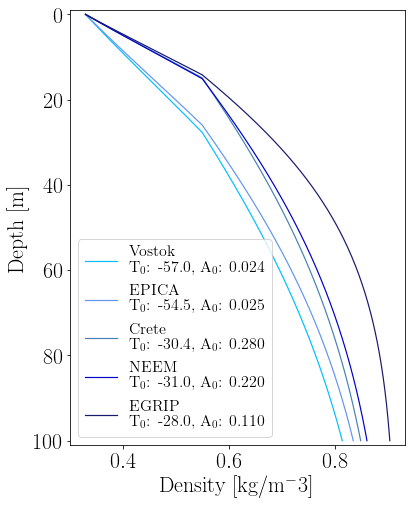

In [25]:
fig, ax = plt.subplots(figsize=(6,8))
i = 0
for model in models:
    HL_model = model
    depth = HL_model['z']
    rhoHL = HL_model['rhoHL']
    zCr = HL_model['zCr']
    zCO = HL_model['zCO']
    rhoCr = 551./1000.
    rhoCO = 804.3/1000

    drho_dz = HL_model['drho_dz']
    drho_dt = HL_model['drho_dt']
    ageHL = HL_model['ageHL']


    ax.plot(rhoHL, depth, lw = 1.2, label = sites[i]+f'\nT$_0$: {T0s[i]-273.15:.1f}, A$_0$: {A0s[i]:.3f}',c=colors[i])
    i += 1

ax.set_ylim((101,-1))
ax.set(xlabel = 'Density [kg/m$^-3$]', ylabel = 'Depth [m]')
    
#ax.axhline(zCr, lw = 1, ls = '--', c = 'k')
#ax.axvline(0.55, lw = 1, ls = '-.', c = 'k')
ax.legend(fontsize=16)


if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'DensProf_Examples.png', bbox_inches='tight')

# Diffusion Length Profile examples

In [21]:
import sys 
import os
sys.path.append('../')

from DiffusionProfiles_calculations import DiffusionLength


In [22]:
sigmaInst = DiffusionLength(P = 0.75, rho_surf = 350.0, f0 = 1, f1 = 1)

i = 0

sigmas = []
zs = []
for model in models:
    HL_model = model
    rhos = 1000*HL_model['rhoHL']
    depths = HL_model['z']


    _, sigma_o18_analyt, _ = sigmaInst.analytical_HL(rhos, T = T0s[i], accum = A0s[i])
    sigma_o18_analytNew = sigma_o18_analyt[sigma_o18_analyt != 0]
    zNew = depths[sigma_o18_analyt != 0]
    sigmas.append(sigma_o18_analytNew)
    zs.append(zNew)
    i += 1

In [23]:
saveFigs = True

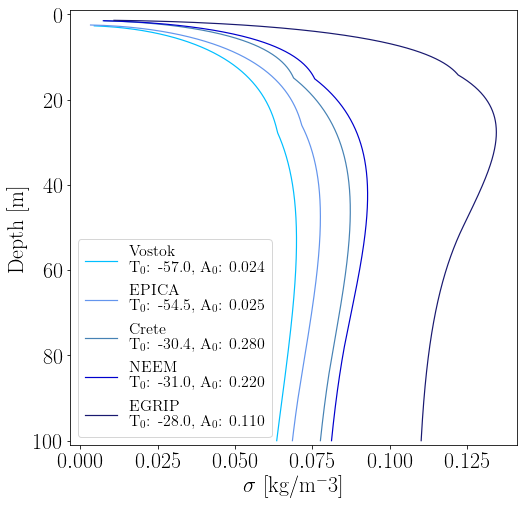

In [24]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_ylim((101,-1))
ax.set(xlabel = '$\sigma$ [kg/m$^-3$]', ylabel = 'Depth [m]')

for i in range(len(sigmas)):
    ax.plot(sigmas[i], zs[i], lw = 1.2, label = sites[i]+f'\nT$_0$: {T0s[i]-273.15:.1f}, A$_0$: {A0s[i]:.3f}',c=colors[i])

#ax.axhline(zCr, lw = 1, ls = '--', c = 'k')
#ax.axvline(0.55, lw = 1, ls = '-.', c = 'k')
ax.legend(fontsize=16)

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'DiffProf_Examples.png', bbox_inches='tight')

# Contour plot, [Gkinis 2021]

#### Initialize parameters

In [98]:
P = 0.7
rho = 804.3
f0 = 1
f1 = 1 

temps = np.linspace(-31,-27,100) + 273.15
accums_ice = np.logspace(-0.7, -0.4, 100) 

fileout = '/home/thea/Documents/KUFysik/MesterTesen/test'

In [99]:
sigma_o18_analyt = np.array([])
sigma_D_analyt = np.array([])
delsigma_sq_analyt = np.array([])


In [100]:
fileout_nlt = fileout + '.nlt'
fileout_inp = fileout + '.inp'
f_nlt = open(fileout_nlt, 'w')
f_inp = open(fileout_inp, 'w')


In [101]:
inputs = np.transpose(np.vstack((temps,accums_ice)))
np.savetxt(f_inp, inputs, fmt = ("%0.3f\t%0.5f"))

f_inp.close()

In [102]:
accums = accums_ice * (917/1000)

In [103]:
accums

array([0.18296555, 0.18424667, 0.18553675, 0.18683586, 0.18814408,
       0.18946145, 0.19078804, 0.19212393, 0.19346917, 0.19482382,
       0.19618797, 0.19756166, 0.19894497, 0.20033797, 0.20174073,
       0.2031533 , 0.20457577, 0.20600819, 0.20745065, 0.2089032 ,
       0.21036593, 0.21183889, 0.21332217, 0.21481584, 0.21631997,
       0.21783462, 0.21935989, 0.22089583, 0.22244253, 0.22400005,
       0.22556849, 0.2271479 , 0.22873838, 0.23033999, 0.23195281,
       0.23357693, 0.23521242, 0.23685936, 0.23851783, 0.24018792,
       0.24186969, 0.24356325, 0.24526866, 0.24698602, 0.2487154 ,
       0.25045688, 0.25221057, 0.25397653, 0.25575485, 0.25754563,
       0.25934895, 0.26116489, 0.26299355, 0.26483501, 0.26668937,
       0.26855671, 0.27043712, 0.2723307 , 0.27423754, 0.27615774,
       0.27809137, 0.28003855, 0.28199936, 0.2839739 , 0.28596227,
       0.28796455, 0.28998086, 0.29201129, 0.29405593, 0.29611489,
       0.29818826, 0.30027616, 0.30237867, 0.30449591, 0.30662

In [104]:
for accum in accums:
    print("accum: %0.2e" %(accum))
    delsigma_sq_analyt = np.array([])
    sigma_o18_analyt = np.array([])
    sigma_D_analyt = np.array([])
    for temp in temps:
        sigma_inst = DiffusionLength(P, f0 = f0, f1 = f1, rho_surf = 350.1)
        
        sigma_o18_analyt_i = sigma_inst.analytical_HL(rho, T = temp, accum = accum)[1]
        sigma_o18_analyt = np.append(sigma_o18_analyt,sigma_o18_analyt_i)
        
        sigma_D_analyt_i = sigma_inst.analytical_HL(rho, T = temp, accum = accum)[0]
        sigma_D_analyt_i = sigma_D_analyt_i*rho/917.
        sigma_D_analyt = np.append(sigma_D_analyt, sigma_D_analyt_i)
        
        delsigma_sq_analyt_i = sigma_o18_analyt_i**2 - sigma_D_analyt_i**2
        delsigma_sq_analyt = np.append(delsigma_sq_analyt, delsigma_sq_analyt_i)
        
        print("\t\tTemp: %0.2f" %(temp))
    np.savetxt(f_nlt, np.reshape(sigma_o18_analyt, (1,-1)), delimiter = "\t", fmt = ("%0.3f"))

accum: 1.83e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 2

		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 1.91e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 2

		Temp: 246.11
		Temp: 246.15
accum: 1.98e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 2

		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.13e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 2

		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.22e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 2

		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.32e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 2

		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.42e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 2

		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.52e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 2

		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.6

		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.76e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 2

		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 2.88e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 2

		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 3.02e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 2

		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 3.15e-01
		Temp: 242.15
		Temp: 242.19
		Temp: 242.23
		Temp: 242.27
		Temp: 242.31
		Temp: 242.35
		Temp: 242.39
		Temp: 242.43
		Temp: 2

		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 245.67
		Temp: 245.71
		Temp: 245.75
		Temp: 245.79
		Temp: 245.83
		Temp: 245.87
		Temp: 245.91
		Temp: 245.95
		Temp: 245.99
		Temp: 246.03
		Temp: 246.07
		Temp: 246.11
		Temp: 246.15
accum: 3.2

		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 245.10
		Temp: 245.14
		Temp: 245.18
		Temp: 245.22
		Temp: 245.26
		Temp: 245.30
		Temp: 245.34
		Temp: 245.38
		Temp: 245.42
		Temp: 245.46
		Temp: 245.50
		Temp: 245.54
		Temp: 245.58
		Temp: 245.62
		Temp: 24

		Temp: 242.43
		Temp: 242.47
		Temp: 242.51
		Temp: 242.55
		Temp: 242.59
		Temp: 242.63
		Temp: 242.68
		Temp: 242.72
		Temp: 242.76
		Temp: 242.80
		Temp: 242.84
		Temp: 242.88
		Temp: 242.92
		Temp: 242.96
		Temp: 243.00
		Temp: 243.04
		Temp: 243.08
		Temp: 243.12
		Temp: 243.16
		Temp: 243.20
		Temp: 243.24
		Temp: 243.28
		Temp: 243.32
		Temp: 243.36
		Temp: 243.40
		Temp: 243.44
		Temp: 243.48
		Temp: 243.52
		Temp: 243.56
		Temp: 243.60
		Temp: 243.64
		Temp: 243.69
		Temp: 243.73
		Temp: 243.77
		Temp: 243.81
		Temp: 243.85
		Temp: 243.89
		Temp: 243.93
		Temp: 243.97
		Temp: 244.01
		Temp: 244.05
		Temp: 244.09
		Temp: 244.13
		Temp: 244.17
		Temp: 244.21
		Temp: 244.25
		Temp: 244.29
		Temp: 244.33
		Temp: 244.37
		Temp: 244.41
		Temp: 244.45
		Temp: 244.49
		Temp: 244.53
		Temp: 244.57
		Temp: 244.61
		Temp: 244.66
		Temp: 244.70
		Temp: 244.74
		Temp: 244.78
		Temp: 244.82
		Temp: 244.86
		Temp: 244.90
		Temp: 244.94
		Temp: 244.98
		Temp: 245.02
		Temp: 245.06
		Temp: 24

In [105]:
f_nlt.close()


In [106]:
sigma_o18_nlt = np.loadtxt(fileout_nlt)*100

In [107]:
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator, FixedFormatter, ScalarFormatter


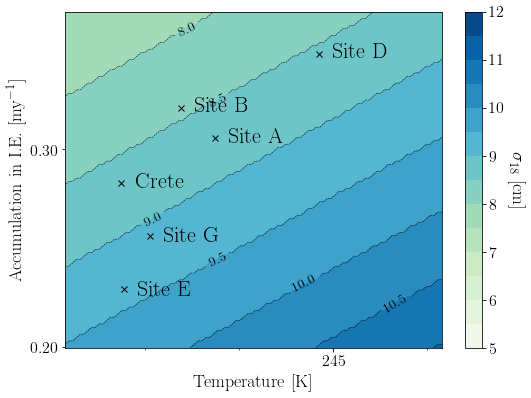

In [124]:
plt.figure(1, tight_layout = True, figsize=(8,6))
ax = plt.gca()

ax.set_yscale('log')
#ax.set_xscale('linear')
ax.set_yticks([], minor=True)

evalu = np.array([5., 5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.,11.5, 12.])
evalu2 = np.array([8., 8.5, 9., 9.5, 10., 10.5, 11.])#np.array([6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.])#

CPf = plt.contourf(temps,accums_ice,sigma_o18_nlt, evalu, cmap=cm.GnBu)
cbar = plt.colorbar()
cbar.set_label(label='$\sigma_{18}$ [cm]', rotation = 270, labelpad=20, fontsize=18)
cbar.ax.tick_params(labelsize=16)

CP = plt.contour(temps,accums_ice,sigma_o18_nlt, evalu,colors='k', linewidths=0.5, linestyles='dashed')
plt.clabel(CP, evalu2[::], colors='k',inline=True, fontsize=14, fmt="%0.1f")

plt.plot(-30.4 + 273.15, 0.28, "kx")
plt.text(-30.4 + 273.15 + 0.15, 0.28 - 0.003, "Crete")

plt.plot(-29.41 + 273.15, 0.307, "kx")
plt.text(-29.41 + 273.15 + 0.15, 0.307 - 0.003, "Site A")

plt.plot(-29.77 + 273.15, 0.327, "kx")
plt.text(-29.77 + 273.15 + 0.15, 0.327 - 0.003, "Site B")

plt.plot(-28.3 + 273.15, 0.365, "kx")
plt.text(-28.3 + 273.15 + 0.15, 0.365 - 0.003, "Site D")

plt.plot(-30.37 + 273.15, 0.225, "kx")
plt.text(-30.37 + 273.15 + 0.15, 0.225 - 0.003, "Site E")

plt.plot(-30.1 + 273.15, 0.251, "kx")
plt.text(-30.1 + 273.15 + 0.15, 0.251 - 0.003, "Site G")


majorxLocator = MultipleLocator(5)
majorxFormatter = FormatStrFormatter('%d')
minorxLocator = MultipleLocator(1)

majoryLocator = MultipleLocator(0.1)#FixedLocator([0.2, 0.3, 0.4, 0.6])
majoryFormatter = FormatStrFormatter('%1.2f')#FixedFormatter(['0.2', '0.3', '0.4', '0.6'])
minoryLocator   = MultipleLocator(0.01)

ax.xaxis.set_major_locator(majorxLocator)
ax.xaxis.set_major_formatter(majorxFormatter)
ax.xaxis.set_minor_locator(minorxLocator)
ax.tick_params(axis = 'both', which = 'major', labelsize=16)


ax.yaxis.set_major_locator(majoryLocator)
ax.yaxis.set_major_formatter(majoryFormatter)


plt.xlabel('Temperature [K]', fontsize = 18)
plt.ylabel('Accumulation in I.E. $[\mathrm{my}^{-1}]$', fontsize = 18)


saveFigs = True
if saveFigs:
    plt.savefig('../../WrittenWork/Figures/'+'ContourPlot_Alphabet.png', bbox_inches='tight')

# Diffusion equation: Diff and dens terms contributions

In [157]:
from numpy import random 
from scipy.optimize import leastsq
from matplotlib import animation

import h5py
import json
import shutil
import time
import diffusivity

In [158]:
filepath = "/home/thea/MesterTesen/CFM-thea/cfm_mytests/steady_state_test_results_temp__2/isoCFM_stst_070421_result__2.hdf5"
f1 = h5py.File(filepath, 'r')
print(f1.keys())

<KeysViewHDF5 ['Modelclimate', 'age', 'density', 'depth', 'drho_dt', 'iso_dsigma2_dt_17', 'iso_dsigma2_dt_18', 'iso_dsigma2_dt_D', 'iso_sigma17', 'iso_sigma18', 'iso_sigmaD', 'temperature']>


In [159]:
depth = f1['depth'][-1][1:]
temp = f1['temperature'][-1][1:]
sigma18 = f1['iso_sigma18'][-1][1:]
dsigma2 = f1['iso_dsigma2_dt_18'][-1][1:]
drho_dt = f1['drho_dt'][-1][1:]
rho = f1['density'][-1][1:]
diffusivity_18 = diffusivity.FirnDiffusivity(P = 0.63, T = temp, rho = rho).o18()

In [160]:
d_up = depth[rho < 550]
d_low = depth[rho > 551]

dsigma2_up = dsigma2[rho < 550]
dsigma2_low = dsigma2[rho > 551]

diffusivity_18_up = diffusivity_18[rho < 550]
diffusivity_18_low = diffusivity_18[rho > 551]

dens_up = drho_dt[rho<550.]*sigma18[rho<550.]**2/rho[rho<550.]
dens_low = drho_dt[rho>551.]*sigma18[rho>551.]**2/rho[rho>551.]

/usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


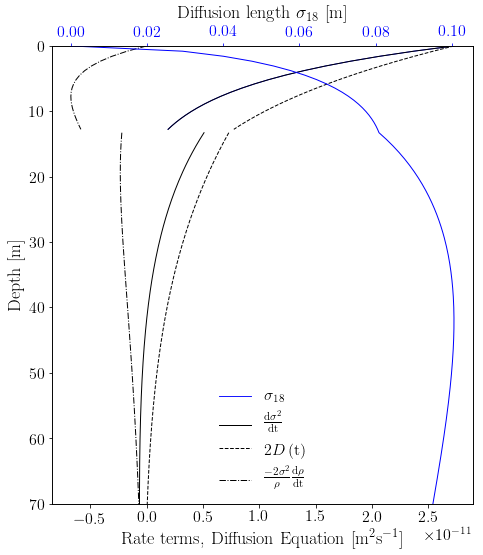

In [161]:
mpl.rcParams['font.size'] = 16

fig, ax = plt.subplots(num = 4323, figsize = (7,8), tight_layout = True)
l2, = ax.plot(dsigma2_up, d_up, color = 'b', lw = .9, ls = 'solid', label = r"$\sigma_{18}$")
l1, = ax.plot(dsigma2_up, d_up, color='k', lw=1, ls = 'solid', label = r"$\frac{\mathrm{d}\sigma^2}{\mathrm{dt}}$")
l3, = ax.plot(2*diffusivity_18_up, d_up, color='k', lw = 1, ls = 'dashed', label = r"$2D\left(\mathrm{t}\right)$")
l4, = ax.plot(-2*dens_up, d_up, color = 'k', lw = 1, ls = 'dashdot', label = r"$\frac{-2\sigma^2}{\rho}\frac{\mathrm{d}\rho}{\mathrm{dt}}$")

axN = ax.twiny()
axN.plot(sigma18, depth, color = 'blue', lw = 1, label = '$\sigma_{18}$')

ax.plot(dsigma2_low, d_low, color='k', lw=1)
ax.plot(2*diffusivity_18_low, d_low, color='k', lw = 1, ls = 'dashed')
ax.plot(-2*dens_low, d_low, color = 'k', lw = 1, ls = 'dashdot')



ax.set_ylim((70,0))
ax.set_ylabel(r'Depth [m]', fontsize=18)
ax.set_xlabel(r'Rate terms, Diffusion Equation [$\mathrm{m}^2\mathrm{s}^{-1}$]', fontsize = 18)
axN.set_xlabel(r'Diffusion length $\sigma_{18}$ [m]', fontsize = 18)
axN.tick_params(axis='x', labelcolor='blue', color='blue')

ax.legend(loc = 'lower center', frameon=False)

if saveFigs:
    plt.savefig('../../WrittenWork/Figures/'+'Analytical_DiffLenEq_terms_SiteA.png', bbox_inches='tight')
    

# Firn and ice Diffusion

# Thinning function

# Diffusion types v. depth